In [1]:
# --- Set location of XASNet code
import sys
sys.path.append('/home/samjhall/github/XASNet-XAI/src')
#sys.path.append('D:\github\XASNet-XAI\src')
# --- Standard libraries
import os.path as osp
# --- PyTorch
import torch
# --- XASNet
from XASNet.models import XASNet_GNN
from XASNet.utils import GraphDataProducer
from XASNet.utils.visualisation import plot_prediction
from XASNet.utils.rse import rse_predictions, rse_loss, rse_histogram

In [2]:
# --- Load in the test dataset
test_go = torch.load('./XASNet-data/test_mol_dataset.pt')

In [3]:
# --- Print details of the dataset
print(f'Number of graphs: {len(test_go)}')
print('')

# --- Print details of the first molecule/graph in the dataset
data = test_go[0]

print(data)
print('------------')
print(f'Molecule index: {data.idx}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 39

Data(x=[30, 10], edge_index=[2, 72], edge_attr=[72, 6], spectrum=[200], idx=[1], smiles='[c:0]12[c:2]3[cH:1][cH:25][c:24]4[c:22]1[c:18]1[c:13]5[c:10]6[c:4]2[c:6]([c:5]([C:8](=[O:27])[OH:28])[cH:3]3)[C:7](=[O:9])[CH2:11][c:12]6[cH:29][c:14]([OH:26])[c:15]5[C:16](=[O:17])[CH2:19][c:20]1[cH:21][cH:23]4')
------------
Molecule index: tensor([238])
Number of nodes: 30
Number of edges: 72
Average node degree: 2.40
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [4]:
# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Set ML model parameters to match the loaded model
xasnet_gnn = XASNet_GNN(
    gnn_name = 'gcn', # model type
    in_channels = [10, 100, 200, 300], # input nodes for each layer
    out_channels = [100, 200, 300, 300], # output nodes for each layer
    num_targets = 200, # nodes for final layers
    num_layers = 4, # number of layers
    heads = 1
).to(device)

# --- Location of the ML model
path_to_model = osp.join('./best_model/xasnet_model.pt')

# --- Check if there is an existing model
if osp.exists(path_to_model):
    xasnet_gnn.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

In [40]:
# --- Choose a molecule to predict spectra from
mol_idx = 299

# --- Set up model to predict spectra
graph_picker = GraphDataProducer(
    model=xasnet_gnn,
    gnn_type="gcn",
    test_data=test_go,
    idx_to_pick=mol_idx
)
graph = graph_picker.picked_graph

In [41]:
# --- Set variables for the spectra
y_true = graph.spectrum
# --- Predict spectrum from ML model
x_pred, y_pred = graph_picker.predictions()

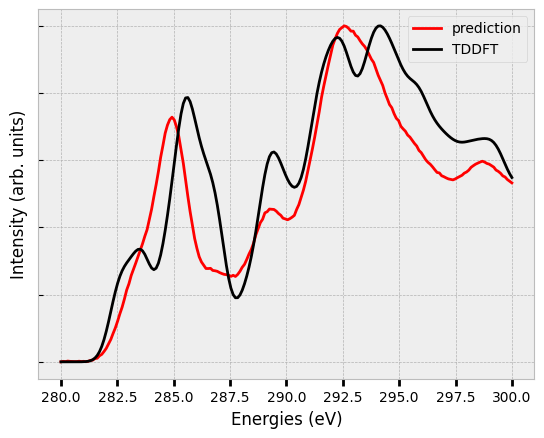

In [42]:
# --- Plot the ML predicted spectrum againsts the true TDDFT spectrum
plot_prediction(x_pred,
                y_pred,
                y_true,
                normalise=True,
                add_peaks=False,
                save=False)

In [8]:
from scipy.stats import spearmanr

spear = spearmanr(y_true, y_pred)

print(spear)
print(spear[0])

SignificanceResult(statistic=0.8969699242481064, pvalue=4.084861108873587e-72)
0.8969699242481064


In [9]:
import numpy as np

for i in range(200):
    if y_pred[i] < 0:
        y_pred[i] = 0.00000000001

sid = 0

for i in range(200):
    temp = y_pred[i] * np.log(y_pred[i]/y_true[i]) + y_true[i] * np.log(y_true[i]/y_pred[i])
    sid = sid + temp

print(sid)

tensor(7.4559, dtype=torch.float64)


In [10]:
rse_dict = rse_predictions(xasnet_gnn, test_go, graphnet=False)

In [11]:
rse_dict = {k: v.numpy() for k, v in rse_dict.items() if v < 1}

In [12]:
rse_loss(y_pred, y_true)

tensor(0.0477, dtype=torch.float64)

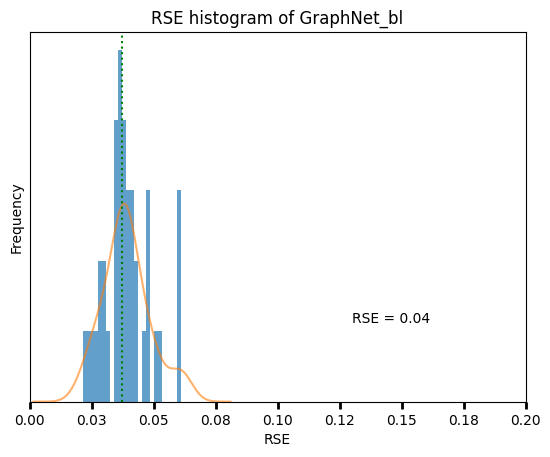

In [13]:
rse_histogram(list(rse_dict.values()), 
              bins=25, 
              quantiles=False,
              model_name="GraphNet_bl", 
              save=False)

In [36]:
min_rse = 1
max_rse = 0

for k, v in rse_dict.items():
    if v < min_rse:
        min_idx = k
        min_rse = v

    if v > max_rse:
        max_idx = k
        max_rse = v

print(f'Lowest RSE value: {min_rse}, belonging the graph index: {min_idx}')
print(f'Highest RSE value: {max_rse}, belonging to the graph index: {max_idx}')

Lowest RSE value: 0.021425883787461047, belonging the graph index: tensor([71])
Highest RSE value: 0.06115237646886853, belonging to the graph index: tensor([299])


In [27]:
average = 0

for idx, rse_val in rse_dict.items():
    average += rse_val

average = average / len(rse_dict)

print(f'Average RSE value of test data: {average}')

Average RSE value of test data: 0.03922266770238598


In [28]:
rse_dict

{tensor([238]): array(0.03992244),
 tensor([134]): array(0.04772928),
 tensor([28]): array(0.03701246),
 tensor([44]): array(0.02871836),
 tensor([71]): array(0.02142588),
 tensor([231]): array(0.03722524),
 tensor([299]): array(0.06115238),
 tensor([115]): array(0.04707707),
 tensor([9]): array(0.03651729),
 tensor([154]): array(0.04172446),
 tensor([274]): array(0.03770891),
 tensor([113]): array(0.03845684),
 tensor([79]): array(0.03518079),
 tensor([236]): array(0.06101978),
 tensor([22]): array(0.03030605),
 tensor([120]): array(0.02746478),
 tensor([188]): array(0.04345749),
 tensor([163]): array(0.05166051),
 tensor([18]): array(0.04558386),
 tensor([204]): array(0.02370416),
 tensor([196]): array(0.04235252),
 tensor([171]): array(0.03010427),
 tensor([301]): array(0.0397307),
 tensor([281]): array(0.03887462),
 tensor([271]): array(0.03847308),
 tensor([20]): array(0.03571553),
 tensor([267]): array(0.03999297),
 tensor([207]): array(0.05128908),
 tensor([132]): array(0.036559